# Disease Classification from Gene Expression Data (ALL vs AML)

This notebook performs data loading, preprocessing, exploratory data analysis,
dimensionality reduction (PCA), and a baseline machine learning model
(Logistic Regression) using the Golub leukemia microarray dataset.


Import Lib


In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Nice plotting defaults
sns.set(style="whitegrid", context="notebook")

# Paths (adjust if needed)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

DATA_RAW, DATA_PROCESSED


(WindowsPath('E:/UTA MSDS/FALL 2025/Bioinformatics/Final Project/Machine-Learning-Based-Prediction-of-Cancer-Subtypes-from-Gene-Expression-Profiles/data/raw'),
 WindowsPath('E:/UTA MSDS/FALL 2025/Bioinformatics/Final Project/Machine-Learning-Based-Prediction-of-Cancer-Subtypes-from-Gene-Expression-Profiles/data/processed'))

Load raw data

In [9]:
train_path = DATA_RAW / "data_set_ALL_AML_train.csv"
ind_path = DATA_RAW / "data_set_ALL_AML_independent.csv"
labels_path = DATA_RAW / "actual.csv"

train = pd.read_csv(train_path)
ind = pd.read_csv(ind_path)
labels = pd.read_csv(labels_path)

train.shape, ind.shape, labels.shape


((7129, 78), (7129, 70), (72, 2))

Quick peek at structure

In [10]:
train.head()


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [11]:
train.columns[:15]


Index(['Gene Description', 'Gene Accession Number', '1', 'call', '2', 'call.1',
       '3', 'call.2', '4', 'call.3', '5', 'call.4', '6', 'call.5', '7'],
      dtype='object')

Helper to detect sample columns (We want to ignore Gene Description, Gene Accession Number, and call columns.)

In [12]:
def get_sample_cols(df: pd.DataFrame):
    return [
        c for c in df.columns
        if c not in ["Gene Description", "Gene Accession Number"]
        and not c.startswith("call")
    ]

train_sample_cols = get_sample_cols(train)
ind_sample_cols = get_sample_cols(ind)

len(train_sample_cols), train_sample_cols[:10], len(ind_sample_cols), ind_sample_cols[:10]


(38,
 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 34,
 ['39', '40', '42', '47', '48', '49', '41', '43', '44', '45'])

Build combined expression matrix (samples × genes)

In [13]:
# Transpose so rows = samples, columns = genes
X_train = train[train_sample_cols].T   # (n_train_samples, n_genes)
X_ind   = ind[ind_sample_cols].T       # (n_ind_samples, n_genes)

X_all = pd.concat([X_train, X_ind], axis=0)

# Index are patient IDs as strings, convert to int
X_all.index = X_all.index.astype(int)
X_all.shape


(72, 7129)

Attach labels (ALL vs AML)

In [14]:
labels.head()


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [15]:
labels = labels.set_index("patient")
y_all = labels.loc[X_all.index, "cancer"]

X_all.shape, y_all.value_counts()


((72, 7129),
 cancer
 ALL    47
 AML    25
 Name: count, dtype: int64)

Save processed dataset

In [16]:
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

df_processed = X_all.copy()
df_processed["cancer"] = y_all

processed_path = DATA_PROCESSED / "all_aml_expression_processed.csv"
df_processed.to_csv(processed_path)

processed_path, df_processed.shape


(WindowsPath('E:/UTA MSDS/FALL 2025/Bioinformatics/Final Project/Machine-Learning-Based-Prediction-of-Cancer-Subtypes-from-Gene-Expression-Profiles/data/processed/all_aml_expression_processed.csv'),
 (72, 7130))

## Exploratory Data Analysis (EDA)
We start with basic label distribution and simple summaries,
followed by PCA to visualize the structure of the samples.


Label distribution plot

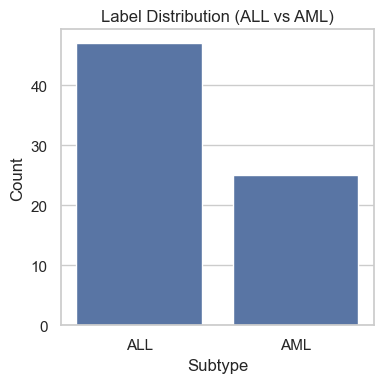

In [17]:
plt.figure(figsize=(4, 4))
sns.countplot(x=y_all)
plt.title("Label Distribution (ALL vs AML)")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Basic gene-level summary

In [18]:
# Quick summary stats across genes (per sample)
df_processed.describe().T.head()


,count,mean,std,min,25%,50%,75%,max
0,72.0,-114.583333,97.738333,-476.0,-148.00,-100.5,-57.50,86.0
1,72.0,-160.125000,96.136631,-531.0,-213.50,-144.0,-96.75,-13.0
2,72.0,-8.069444,122.697995,-410.0,-77.25,-14.0,49.00,312.0
3,72.0,189.347222,111.884014,-36.0,99.50,179.0,277.75,431.0
4,72.0,-253.305556,122.183611,-541.0,-344.25,-227.5,-173.50,114.0


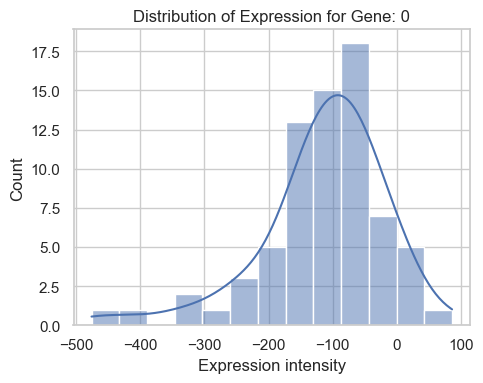

In [19]:
# Distribution of expression values for a random gene
random_gene = X_all.columns[0]
plt.figure(figsize=(5, 4))
sns.histplot(X_all[random_gene], kde=True)
plt.title(f"Distribution of Expression for Gene: {random_gene}")
plt.xlabel("Expression intensity")
plt.tight_layout()
plt.show()


PCA for dimensionality reduction & visualization

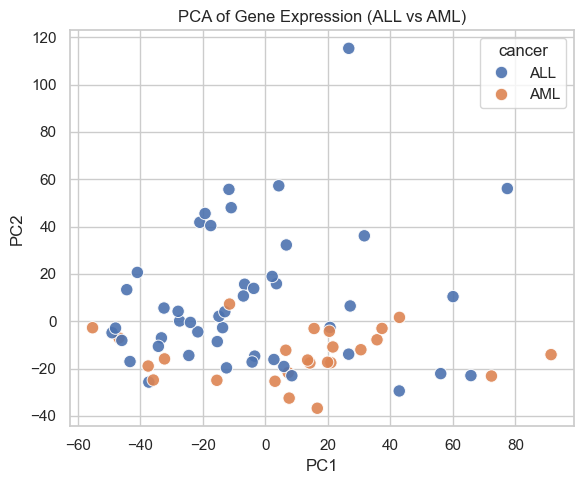

array([0.14921586, 0.09446173])

In [20]:
from sklearn.preprocessing import StandardScaler

X = X_all.values
y = y_all.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cancer": y_all.values
})

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cancer",
    s=80,
    alpha=0.9
)
plt.title("PCA of Gene Expression (ALL vs AML)")
plt.tight_layout()
plt.show()

pca.explained_variance_ratio_


Heatmap of top variable genes (nice visual)

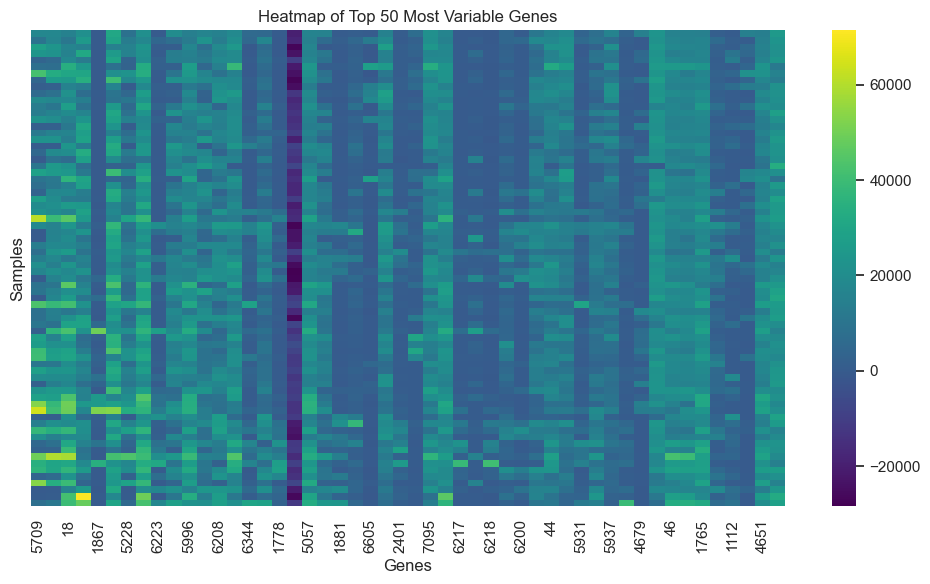

In [21]:
# Compute variance per gene
gene_variances = X_all.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(50).index

plt.figure(figsize=(10, 6))
sns.heatmap(
    X_all[top_genes],
    cmap="viridis",
    cbar=True,
    yticklabels=False
)
plt.title("Heatmap of Top 50 Most Variable Genes")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()


## Baseline Machine Learning Model

We train a baseline Logistic Regression classifier on the processed
gene expression matrix to predict ALL vs AML, using a stratified
train/test split.


Train-test split + baseline model

In [22]:
from sklearn.model_selection import train_test_split

df = df_processed.copy()
y = df["cancer"]
X = df.drop(columns=["cancer"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

acc, f1


(1.0, 1.0)

Confusion matrix visualization

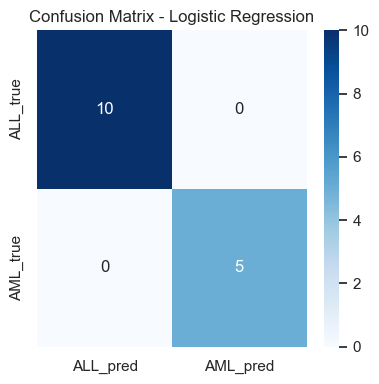

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=["ALL", "AML"])
cm_df = pd.DataFrame(cm, index=["ALL_true", "AML_true"], columns=["ALL_pred", "AML_pred"])

plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


## Summary of Current Progress

- Raw Kaggle files (train, independent, labels) successfully loaded.
- Constructed a unified processed dataset with 72 samples and 7k+ genes.
- Saved processed data to `data/processed/all_aml_expression_processed.csv`.
- Performed basic EDA and visualizations:
  - Label distribution plot
  - PCA projection showing subtype separation
  - Heatmap of top 50 variable genes
- Trained a baseline Logistic Regression model with accuracy and F1 metrics.
- Next steps: try additional models (Random Forest, Gradient Boosting),
  perform feature importance analysis, and interpret top genes biologically.
